__Data Preprocessing__

In [1]:
#Import libraries

from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read car accidents file. Using the sampled version for condensed data

accidents_file_path = 'US_Accidents_March23_sampled_500k.csv'

#Read data in chunks to reduce memory
chunk_size = 100000

accidents = pd.DataFrame()

for chunk in pd.read_csv(accidents_file_path,chunksize=chunk_size, low_memory=False):
    # Process each chunk as needed
    accidents = pd.concat([accidents,chunk])
    

__Checkpoint 1__

In [3]:
#Copy Dataframe to use for analysis
df = accidents.copy()

In [4]:
#Drop irrelevant columns

#Airport Code, ID, Source are irrelevant 
#Extra geographical information like street, county, zipcode, country is redundant
#Twilight and Sunset periods are redundant as we will use start time to denote period of day
#The majority of ending_lat and end_lng are missing and that field doesn't tell us much
#Weather Time stamp and End Time are not needed as we will only use Start Time
#Description details the traffic condictions AFTER the accidents. Ex, lane blocked, slow traffic, lane closed, alernate route
#Dropping Turning Loop since all records are false

df_dropped = df.drop(columns = ['ID','Source', 'End_Time','Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Street','County','Zipcode','Country', 'Airport_Code', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'Civil_Twilight', 'Description', 'Turning_Loop'], axis = 1)

#Change Start time to a date time format

df_dropped['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%m/%d/%y %H:%M', errors='coerce')
df_dropped['Start_Time']


0        2019-06-12 10:10:00
1        2022-12-03 23:37:00
2        2022-08-20 13:13:00
3        2022-02-21 17:43:00
4        2020-12-04 01:46:00
                 ...        
499995   2021-12-15 07:30:00
499996   2021-12-19 16:25:00
499997   2022-04-13 19:28:00
499998   2020-05-15 17:20:00
499999   2022-04-02 23:23:00
Name: Start_Time, Length: 500000, dtype: datetime64[ns]

In [5]:
#Push or Pull Start Time based on the TimeZone. Reference Timezone will be US/Central

timezone_adjustments = {
    'US/Eastern': -timedelta(hours=1),
    'US/Pacific': timedelta(hours=2),
    'US/Mountain': timedelta(hours=1)
}

new_timezones = {
    'US/Eastern': 'US/Central',
    'US/Pacific': 'US/Central',
    'US/Mountain': 'US/Central'
}

# Filter rows where Timezone is in the timezone_adjustments dictionary
mask = df_dropped['Timezone'].isin(timezone_adjustments)

# Apply adjustments to Start_Time based on Timezone
df_dropped.loc[mask, 'Start_Time'] += df_dropped.loc[mask, 'Timezone'].map(timezone_adjustments)

# Update Timezone to central to make timezone uniform
df_dropped.loc[mask, 'Timezone'] = df_dropped.loc[mask, 'Timezone'].map(new_timezones)

#Create lists for month, day of week, and hour of day based on date/time values

list_months = df_dropped['Start_Time'].dt.month.tolist()
list_days_of_week = (df_dropped['Start_Time'].dt.dayofweek + 1).tolist()
list_hours = df_dropped['Start_Time'].dt.hour.tolist()

#Insert date/time values back into dataframe 

df_dropped['Month'] = list_months
df_dropped['Day of Week'] = list_days_of_week
df_dropped['Time Of Day'] = list_hours


__Checkpoint 2__

In [6]:
df_dropped_categorized = df_dropped.copy()

In [7]:
#Categorize hours into major periods of day 

time_of_day_mapping = {0:'Middle of Night', 1:'Middle of Night', 2:'Middle of Night', 3:'Early Morning', 4:'Early Morning', 
                      5:'Early Morning', 6:'Morning',7:'Morning', 8:'Morning', 9:'Late Morning',10:'Late Morning',
                      11:'Late Morning', 12:'Afternoon', 13:'Afternoon', 14:'Afternoon', 15:'Late Afternoon',
                      16:'Late Afternoon', 17:'Late Afternoon', 18:'Evening', 19:'Evening', 20:'Evening',
                      21:'Night', 22:'Night', 23:'Night'}

df_dropped_categorized['Time Of Day'] = df_dropped_categorized['Time Of Day'].map(time_of_day_mapping)

#Categorize Wind_Direction into 10 total cardinal directions inclduing calm and variable

cardinal_directions = {
    'North': ['N', 'North'],
    'South': ['S', 'South'],
    'East': ['E', 'East'],
    'West': ['W', 'West'],
    'Northeast': ['NE', 'NNE', 'ENE'],
    'Northwest': ['NW', 'NNW', 'WNW'],
    'Southeast': ['SE', 'SSE', 'ESE'],
    'Southwest': ['SW', 'SSW', 'WSW'],
    'Calm': ['CALM'],
    'Variable': ['Variable','Var']
}

df_dropped_categorized['Wind_Direction'] = df_dropped_categorized['Wind_Direction'].map({direction: category for category, directions in cardinal_directions.items() for direction in directions})

#Categorize Weather_Condition into 7 major weather_conditions including an option for other

weather_categories = {
    'Clear Weather': ['Clear', 'Fair', 'N/A Precipitation'],
    'Cloudy Weather': ['Cloudy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy', 'Scattered Clouds', 'Mostly Cloudy / Windy', 'Cloudy / Windy', 'Partly Cloudy / Windy', 'Fair / Windy', 'Haze', 'Haze / Windy', 'Light Haze'],
    'Foggy Weather': ['Fog', 'Light Freezing Fog', 'Mist', 'Partial Fog', 'Patches of Fog', 'Shallow Fog', 'Fog / Windy', 'Partial Fog / Windy'],
    'Rainy Weather': ['Light Freezing Rain','Heavy Drizzle','Light Rain', 'Light Rain with Thunder', 'Rain', 'Rain Showers', 'Showers in the Vicinity', 'Heavy Rain', 'Thunderstorms and Rain', 'Heavy Thunderstorms and Rain', 'Light Rain / Windy', 'Rain / Windy', 'Heavy Rain / Windy', 'Rain Shower', 'Rain Showers', 'Light Rain Shower', 'Light Rain Shower / Windy', 'Rain Shower / Windy'],
    'Snowy Weather': ['Ice Pellets','Light Ice Pellets','Wintry Mix','Light Snow', 'Snow', 'Snow / Windy', 'Heavy Snow', 'Light Snow / Windy', 'Heavy Snow / Windy', 'Light Snow Shower', 'Light Snow Showers', 'Snow Shower', 'Snow Showers', 'Light Snow and Sleet', 'Snow and Sleet', 'Snow and Sleet / Windy', 'Light Snow and Sleet / Windy'],
    'Thunderstorms': ['Thunder', 'T-Storm', 'Thunder in the Vicinity', 'Thunderstorm', 'Heavy T-Storm', 'T-Storm / Windy', 'Thunder / Windy', 'Thunder / Wintry Mix', 'Light Thunderstorms and Rain', 'Light Thunderstorms and Snow', 'Thunder and Hail'],
    'Windy Weather': ['Blowing Dust / Windy', 'Blowing Snow / Windy', 'Blowing Dust', 'Blowing Snow', 'Squalls / Windy', 'Widespread Dust / Windy', 'Widespread Dust', 'Sand / Dust Whirlwinds', 'Sand', 'Squalls', 'Drifting Snow / Windy', 'Drifting Snow', 'Mist / Windy', 'Smoke / Windy', 'Smoke', 'Freezing Rain / Windy', 'Sleet / Windy', 'Snow / Windy', 'Wintry Mix / Windy', 'Light Drizzle / Windy', 'Drizzle / Windy', 'Haze / Windy'],
    'Other Weather Conditions': ['Funnel Cloud', 'Tornado', 'Volcanic Ash','Light Hail', 'Small Hail', 'Heavy Sleet', 'Light Sleet', 'Snow Grains', 'Light Snow Grains', 'Light Snow with Thunder']
}


df_dropped_categorized['Weather_Condition'] = df_dropped_categorized['Weather_Condition'].map({condition: category for category, conditions in weather_categories.items() for condition in conditions})


In [8]:
#Binarize Severity as the ranking of severity doesn't have a large meaning. 1-2 have the least impact on traffic resulting in
#a short delay, while 3 and 4 has a significant impact on traffic resulting in a long delay

def binarize_severity(severity):
    if severity == 4 or severity == 3:
        return 'Significant Severity'
    else:
        return 'Low Severity'

df_dropped_categorized['Severity_Binary'] = df_dropped_categorized['Severity'].apply(binarize_severity)

#Drop start time as it is no longer needed and re-order columns
column_names_upd = ['Severity_Binary','Month', 'Day of Week',
       'Time Of Day', 'Distance(mi)','Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal']

df_dropped_categorized = df_dropped_categorized[column_names_upd]

__Checkpoint 3__

In [9]:
df_preprocessed = df_dropped_categorized.copy()

In [10]:
#Drop any rows with an NA value. Logistic Regression does not work with N/A values. This retains about 65% of the overall data

df_preprocessed.dropna(inplace=True)

In [11]:
data_export = df_preprocessed.copy()

In [12]:
#Rename columns since we are standardizing

df_preprocessed.rename(columns={
    'Temperature(F)': 'Temperature',
    'Distance(mi)': 'Distance',
    'Wind_Chill(F)': 'Wind Chill',
    'Visibility(mi)': 'Visibility',
    'Wind_Speed(mph)': 'Wind Speed',
    'Humidity(%)': 'Humidity',
    'Pressure(in)': 'Pressure',
     'Precipitation(in)': 'Precipitation',
    'Severity_binary': 'Severity'
}, inplace=True)


In [13]:
# Split the data into 70% training and 30% testing sets

x = df_preprocessed[['Month', 'Day of Week', 'Time Of Day', 'Distance',
       'Temperature', 'Wind Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Direction', 'Wind Speed', 'Precipitation',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal']]
                    
y = df_preprocessed[['Severity_Binary']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2024)

#Split x into numerical and categorical for both 
x_train_numerical = x_train[['Distance','Temperature', 'Wind Chill','Humidity', 'Pressure', 'Visibility'
                    ,'Wind Speed', 'Precipitation']]

x_train_categorical = x_train[['Month', 'Day of Week', 'Time Of Day', 'Wind_Direction',
                    'Weather_Condition', 'Amenity',
                    'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                    'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']]

x_test_categorical = x_test[['Month', 'Day of Week', 'Time Of Day', 'Wind_Direction',
                    'Weather_Condition', 'Amenity',
                    'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                    'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']]

x_test_numerical = x_test[['Distance','Temperature', 'Wind Chill','Humidity', 'Pressure', 'Visibility'
                    ,'Wind Speed', 'Precipitation']]

In [14]:
#Standardize numerical variables and one hot encode categorical variables.

# Store column names before scaling and encoding
numerical_column_names = x_train_numerical.columns
categorical_column_names = x_train_categorical.columns

scaler = StandardScaler()

# Fit and transform training and testing data
x_train_numerical_scaled_df = pd.DataFrame(scaler.fit_transform(x_train_numerical), columns=numerical_column_names)
x_test_numerical_scaled_df = pd.DataFrame(scaler.transform(x_test_numerical), columns=numerical_column_names)

encoder = OneHotEncoder()

#Encode training data

x_train_categorical_encoded = encoder.fit_transform(x_train_categorical)
x_train_categorical_encoded_df = pd.DataFrame(x_train_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_column_names))

#Encode testing data
x_test_categorical_encoded = encoder.fit_transform(x_test_categorical)
x_test_categorical_encoded_df = pd.DataFrame(x_test_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_column_names))


In [15]:
#Rename caegorical encoded data for readabiity 

current_column_names = x_train_categorical_encoded_df.columns.tolist()

new_column_names = ['January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Afternoon', 'Early Morning',
       'Evening', 'Late Afternoon',
       'Late Morning', 'Middle of Night',
       'Morning', 'Night', 'Calm Wind',
       'East Wind', 'North Wind',
       'Northeast Wind', 'Northwest Wind',
       'South Wind', 'Southeast Wind',
       'Southwest Wind', 'Variable Wind',
       'West Wind', 'Clear Weather',
       'Cloudy Weather', 'Foggy Weather',
       'Other Weather Conditions',
       'Rainy Weather', 'Snowy Weather',
       'Thunderstorms', 'Windy Weather',
       'Amenity False', 'Amenity True', 'Bump False', 'Bump True',
    'Crossing False', 'Crossing True', 'GiveWay False', 'GiveWay True',
    'Junction False', 'Junction True', 'NoExit False', 'NoExit True',
    'Railway False', 'Railway True', 'Roundabout False', 'Roundabout True',
    'Station False', 'Station True', 'Stop False', 'Stop True',
    'TrafficCalming False', 'TrafficCalming True', 'TrafficSignal False',
    'TrafficSignal True']

column_rename_dict = dict(zip(current_column_names, new_column_names))

x_train_categorical_encoded_df = x_train_categorical_encoded_df.rename(columns=column_rename_dict)
    
x_test_categorical_encoded_df = x_test_categorical_encoded_df.rename(columns=column_rename_dict)

#Drop False instances of encoded categorical data, as they are not needed given we have a true flag.

x_train_categorical_encoded_df  = x_train_categorical_encoded_df.drop(columns=
        ['Amenity False', 'Bump False', 'Crossing False', 'GiveWay False', 'Junction False','NoExit False', 'Railway False'
         ,'Roundabout False','Station False','Stop False','TrafficCalming False',
    'TrafficSignal False'])

x_test_categorical_encoded_df  = x_test_categorical_encoded_df.drop(columns=
        ['Amenity False', 'Bump False', 'Crossing False', 'GiveWay False', 'Junction False','NoExit False', 'Railway False'
         ,'Roundabout False','Station False','Stop False','TrafficCalming False',
    'TrafficSignal False'])

#Put both back together for final training and testing sets
x_train_final = pd.concat([x_train_numerical_scaled_df, x_train_categorical_encoded_df],axis=1)
x_test_final = pd.concat([x_test_numerical_scaled_df, x_test_categorical_encoded_df],axis=1)

In [16]:
# Initialize logistic regression model
model = LogisticRegression(solver = 'lbfgs', n_jobs=-1, penalty = None)

# Fit the model
model.fit(x_train_final, np.ravel(y_train))

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print()

#Accuracy of Model
accuracy = model.score(x_test_final, y_test)
print("Accuracy:", accuracy)
print()

#Model Classes
classes = model.classes_

print("Class 0:", classes[0])
print("Class 1:", classes[1])


Coefficients: [[-0.05523316  0.12005238 -0.33770077 -0.00959587 -0.03088959  0.02758021
   0.01090914  0.01282017 -0.58007458 -0.48472552 -0.16108138  0.10357141
   0.28230281  0.44014429  0.32803254  0.29173608  0.00094489 -0.14479237
  -0.45516295 -0.68254344 -0.15066721 -0.17855668 -0.16859171 -0.22306227
  -0.18566903 -0.11824029 -0.03686104 -0.04512656 -0.10266739  0.04125724
   0.0108618  -0.05580425 -0.64876633 -0.03273684 -0.2286659  -0.2355601
  -0.09463497 -0.11370366 -0.0853621  -0.1976796  -0.04524644 -0.05982929
  -0.10705635  0.07280482 -0.19538055 -0.33171571 -0.11294226 -0.27404503
  -0.00535991  0.11905485 -0.01715766 -0.10613401 -0.33334849 -0.50234688
  -0.02999521 -0.80676668  0.24872971  0.21301617  0.01646076  0.35636242
  -0.01474854 -0.79804526 -0.90668453  0.00893206 -0.48855749]]
Intercept: [-1.06164823]

Accuracy: 0.8622351672954932

Class 0: Low Severity
Class 1: Significant Severity


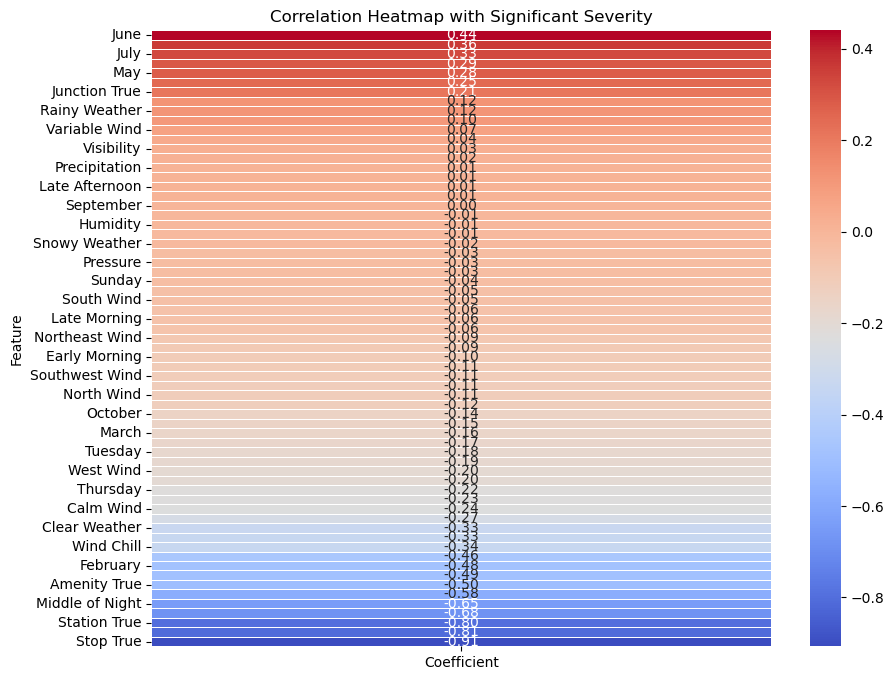

In [17]:
#Chart out a heatmap of each of the predictors and their correlation with significant severity 

coefficients = model.coef_[0]

# Create a DataFrame with feature names and coefficients
coef_df = pd.DataFrame({'Feature': x_test_final.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient values
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(coef_df.set_index('Feature'), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap with Significant Severity')
plt.show()


__Final Checkpoint__

In [13]:
#Final exports for use in BI Tool
Correlation_Export = coef_df.to_csv('C:/Users/SethDasuki/OneDrive - Turnberry Solutions Inc/Desktop/Sample_Accidents_Correlations.csv')
Data_Export = data_export.to_csv('C:/Users/SethDasuki/OneDrive - Turnberry Solutions Inc/Desktop/Sample_Accidents_Data.csv')

__REFERENCES__

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, arXiv preprint arXiv:1906.05409 (2019).

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. “Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights.” In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.